In [1]:
%matplotlib inline

In [2]:
import os
import pickle
import sys
from collections import Counter, defaultdict
from copy import deepcopy
from itertools import combinations, product
import pandas as pd
import json

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import powerlaw
from joblib import Parallel, delayed
from matplotlib import colors
from networkx.algorithms.community.quality import modularity as nx_modularity
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.utils.testing import ignore_warnings
from tqdm.notebook import tqdm

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

sys.path.append('../../pygkernels')
from pygkernels.measure import kernels
from pygkernels.scenario import d3_colors

/home/illusionww/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# Localizaton by SVM

In [3]:
kernels_order = [x.name for x in kernels]
list(enumerate(kernels_order));

In [4]:
# root = '/media/illusionww/68949C3149F4E819/phd/pygkernels/montecarlo_lfr_simple'
# dataset = []
# for fn in tqdm(os.listdir(root)):
#     with open(f'{root}/{fn}', 'rb') as f:
#         dataset.append(json.load(f))
        
with open('filtered_dataset.json', 'r') as f:
    dataset = json.load(f)
    
idx_several_answers = [idx for idx, d in enumerate(dataset) 
                       if np.sum(np.max(np.array(list(d['measure_best_results'].values()))) == np.array(list(d['measure_best_results'].values()))) > 1]
idx_several_answers = set(idx_several_answers)

dataset = [d for idx, d in enumerate(dataset) if idx not in idx_several_answers]

In [5]:
lfr_feature_names = [
    'n',
    'tau1|inv',
    'tau2|inv',
    'mu',
    'avg_degree|log',
    'min_degree|log',
    'max_degree|log',
    'min_community|log',
    'avg_community|log',
    'max_community|log',
]

graph_feature_names = [
    'n',
    'tau1|inv',
    'min_degree|log',
    'avg_degree|log',
    'max_degree|log',
    'min_density',
    'avg_density',
    'max_density',
    'diameter',
    'avg_sp',
    'assortativity',
    'avg_clustering'
]

all_feature_names = [
    'n',
    'tau1|inv',
    'min_degree|log',
    'avg_degree|log',
    'max_degree|log',
    'min_density',
    'avg_density',
    'max_density',
    'diameter',
    'avg_sp',
    'assortativity',
    'avg_clustering',
    
    'k', 'k|inv',
    'tau2|inv',
    'min_community|log',
    'avg_community|log',
    'max_community|log',
    'min_community/n',
    'avg_community/n',
    'max_community/n',
    'mu',
    'mu/avg_density|log',
    'modularity'
]

feature_min = {fn: np.min([data['estimated_params'][fn] for data in dataset]) for fn in all_feature_names}
feature_max = {fn: np.max([data['estimated_params'][fn] for data in dataset]) for fn in all_feature_names}
feature_width = {fn: feature_max[fn] - feature_min[fn] for fn in all_feature_names}
feature_normalize = lambda x, fn: (x - feature_min[fn]) / feature_width[fn]

for fn in all_feature_names:
    print(f'{fn}: {feature_min[fn]:.2f}, {feature_max[fn]:.2f} | '
          f'{feature_normalize(feature_min[fn], fn):.2f}, {feature_normalize(feature_max[fn], fn):.2f}')

n: 10.00, 1499.00 | 0.00, 1.00
tau1|inv: 0.47, 1.00 | 0.00, 1.00
min_degree|log: 0.00, 6.90 | 0.00, 1.00
avg_degree|log: 0.86, 7.07 | 0.00, 1.00
max_degree|log: 1.39, 7.29 | 0.00, 1.00
min_density: 0.00, 0.77 | 0.00, 1.00
avg_density: 0.00, 0.88 | 0.00, 1.00
max_density: 0.02, 1.06 | 0.00, 1.00
diameter: 2.00, 12.00 | 0.00, 1.00
avg_sp: 1.12, 6.03 | 0.00, 1.00
assortativity: -0.66, 0.20 | 0.00, 1.00
avg_clustering: 0.01, 0.88 | 0.00, 1.00
k: 2.00, 268.00 | 0.00, 1.00
k|inv: 0.50, 1.00 | 0.00, 1.00
tau2|inv: 0.34, 1.00 | 0.00, 1.00
min_community|log: 0.00, 6.61 | 0.00, 1.00
avg_community|log: 0.09, 6.62 | 0.00, 1.00
max_community|log: 0.69, 7.02 | 0.00, 1.00
min_community/n: 0.00, 0.50 | 0.00, 1.00
avg_community/n: 0.00, 0.50 | 0.00, 1.00
max_community/n: 0.01, 0.87 | 0.00, 1.00
mu: 0.09, 1.00 | 0.00, 1.00
mu/avg_density|log: -0.84, 5.12 | 0.00, 1.00
modularity: -0.46, 0.84 | 0.00, 1.00


In [6]:
class AffineModel(nn.Module):
    def __init__(self, ndim):
        super().__init__()
#         print('ndim', ndim)
        self.layer = nn.Linear(ndim, ndim)
        
    def forward(self, X):
        h = self.layer(X)
        return (torch.clamp(1 - torch.sqrt(torch.sum(torch.pow(h, 2), dim=1)), -3, 1) + 1) / 2  # from -49.5 to 1, with border on 0.5

In [7]:
def mse(y_pred, y_true):
    pos_weight, neg_weight = float(y_true.shape[0]) / torch.sum(y_true == 1).float() / 2, float(y_true.shape[0]) / torch.sum(y_true == 0).float() / 2
#     print(pos_weight, neg_weight)
    weights = y_true * pos_weight + (1 - y_true) * neg_weight
    return torch.mean(weights * (y_pred - y_true) ** 2)

In [8]:
class EllipsoidEstimator:
    def __init__(self, ndim):
        self.model = AffineModel(ndim).to(0)
        with torch.no_grad():
            self.model.layer.weight.fill_(0.)
            for i in range(self.model.layer.weight.shape[0]):
                self.model.layer.weight[i, i] = 1
            self.model.layer.bias.fill_(0.5)
        
    def fit(self, X, y):
        X, y_true = torch.from_numpy(X).float().to(0), torch.from_numpy(y).long().to(0)
        
        best_weights = {
            'weight': None,
            'bias': None
        }
        min_loss = 228*1488
        optimizer = optim.Adam(params=self.model.parameters(), lr=0.001)
        for n_epoch in range(20000):
            optimizer.zero_grad()
            y_pred = self.model(X)
            loss = mse(y_pred, y_true)
            loss.backward()
            optimizer.step()

            if loss < min_loss:
                min_loss = loss.detach()
                with torch.no_grad():
                    best_weights['weight'] = self.model.layer.weight.clone()
                    best_weights['bias'] = self.model.layer.bias.clone()

        with torch.no_grad():
            self.model.layer.weight = torch.nn.Parameter(best_weights['weight'])
            self.model.layer.bias = torch.nn.Parameter(best_weights['bias'])
        
    def predict(self, X):
        X = torch.from_numpy(X).to(0)
        with torch.no_grad():
            y_pred = self.model(X)
        return y_pred.cpu().numpy()
    
    def fit_predict(self, X, y):
        self.fit(X, y)
        return self.predict(X)

In [9]:
tx = np.array([[feature_normalize(item['estimated_params'][fname], fname) for fname in all_feature_names] for item in dataset]).astype(np.float32)
ty = np.array([[item['measure_best_results'][kernel] for kernel in kernels_order] for item in dataset]).astype(np.float32)
print(tx.shape, ty.shape)

# for kernel_name in ['SCCT', 'NHeat', 'Comm', 'RSP', 'logComm', 'SP-CT', 'DF', 'Katz', 'SCT', 'logDF', 'logKatz']:
#     measure_idx = kernels_order.index(kernel_name)
#     y_true = np.argmax(ty, axis=1) == measure_idx
    
#     estimator = EllipsoidEstimator(tx.shape[1])
#     y_pred = estimator.fit_predict(tx, y_true)
#     f1 = f1_score(y_true, y_pred > 0.5)
    
#     print(f'{kernel_name}\t({measure_idx})\t{np.sum(y_true)}\t{f1:.2f}')

(5360, 24) (5360, 25)


## Best 2d projection

In [10]:
class RFE:
    def __init__(self, feature_names, max_features=2, n_jobs=1):
        self.feature_names = feature_names
        self.max_features = max_features
        self.n_jobs = n_jobs
        self.results = {}

    @ignore_warnings(category=ConvergenceWarning)
    def score_one(self, X, y_true, set_feat_names):
        support = np.array([x in set_feat_names for x in self.feature_names], dtype=np.bool)
        estimator = EllipsoidEstimator(ndim=np.sum(support))
#         print(X[:, support].shape, y_true.shape)
        y_pred = estimator.fit_predict(X[:, support], y_true)
#         print(y_pred.shape)
        f1 = f1_score(y_true, y_pred > 0.5)
        return set_feat_names, f1, estimator

    def fit(self, X, y_true):
        # for all features first:
#         _, f1_all, estimator_all = self.score_one(X, y_true, self.feature_names)
#         print(f'all features, f1={f1_all:.3f}')

        for n_features in range(self.max_features, self.max_features + 1):
            results = Parallel(n_jobs=self.n_jobs)(delayed(self.score_one)(X, y_true, set_feat_names)
                                                   for set_feat_names in list(combinations(self.feature_names, n_features)))
            best_n_feat, best_f1, best_estimator = None, 0, None
            for set_feat_names, f1, estimator in results:
                if f1 > best_f1:
                    best_n_feat, best_f1, best_estimator = set_feat_names, f1, estimator
            print(f'{n_features} features, f1={best_f1:.3f}, set={best_n_feat}')
            self.results[n_features] = {
                'set': best_n_feat,
                'f1': best_f1,
                'estimator': best_estimator
            }
        return self
    
    def draw2d(self, ax, X, y_true):
        set_feat_names, f1, estimator = self.results[2]['set'], self.results[2]['f1'], self.results[2]['estimator']
        support = np.array([x in set_feat_names for x in self.feature_names], dtype=np.bool)
        support_idx = [x for x in range(support.shape[0]) if support[x]]
#         print(set_feat_names)
#         print(support)
#         print(support_idx)
        
        y_pred = estimator.predict(X[:, support])
        f1 = f1_score(y_true, y_pred > 0.5)
        print(f'f1: {f1:.3f}')
        
        background = np.zeros((101, 101, 3), dtype=np.uint8)
        background[:] = 255
        flatgrid = np.array(list(product(np.array(range(101)), np.array(range(101)))), dtype=np.int)
        flatgrid2 = np.array(list(product(np.array(range(101)) / 100, np.array(range(101)) / 100)), dtype=np.float32)
        background_flat = estimator.predict(flatgrid2)
        for a, b in zip(flatgrid, background_flat):
            if b > 0.5:
                background[a[1], a[0], :] = 180
            
        ax.imshow(background)

        ax.scatter(X[:, support_idx[0]] * 100, X[:, support_idx[1]] * 100, s=0.2, c=y_true)

        ax.set_xlabel(set_feat_names[0])
        ax.set_ylabel(set_feat_names[1])
        ax.set_xticks(np.arange(0, 100.01, 20))
        ax.set_xticklabels([f'{x:.1f}' for x in np.arange(0, 1.01, 0.2)])
        ax.set_yticks(np.arange(0, 100.01, 20))
        ax.set_yticklabels([f'{x:.1f}' for x in np.arange(0, 1.01, 0.2)])
        
        ax.invert_yaxis()

SCCT
2 features, f1=0.791, set=('avg_degree|log', 'modularity')
f1: 0.791

NHeat
2 features, f1=0.418, set=('diameter', 'modularity')
f1: 0.418

Comm
2 features, f1=0.231, set=('avg_community|log', 'modularity')
f1: 0.231

logComm
2 features, f1=0.309, set=('avg_degree|log', 'modularity')
f1: 0.309

RSP
2 features, f1=0.137, set=('k|inv', 'mu/avg_density|log')
f1: 0.137

SCT
2 features, f1=0.150, set=('k', 'k|inv')
f1: 0.150

logDF
2 features, f1=0.223, set=('avg_degree|log', 'modularity')
f1: 0.223

SP-CT
2 features, f1=0.092, set=('tau1|inv', 'min_community/n')
f1: 0.092

logKatz
2 features, f1=0.127, set=('assortativity', 'modularity')
f1: 0.127



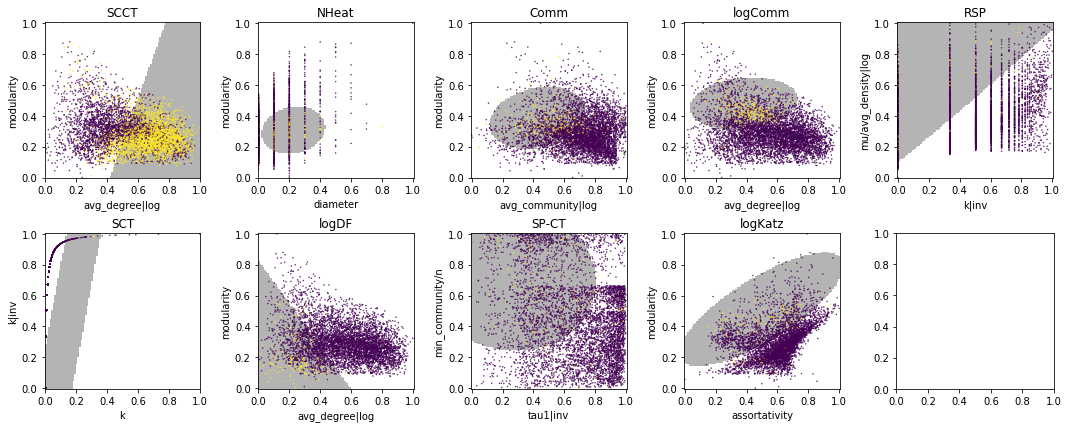

In [11]:
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
ax = np.array(ax).ravel()

for idx, (kernel_name, (fname1, fname2)) in enumerate([
    ('SCCT', ('avg_degree|log', 'modularity')),
    ('NHeat', ('diameter', 'modularity')),
    ('Comm', ('avg_community|log', 'modularity')),
    ('logComm', ('avg_degree|log', 'modularity')),
    ('RSP', ('k|inv', 'mu/avg_density|log')),
    ('SCT', ('k', 'k|inv')),
    ('logDF', ('avg_degree|log', 'modularity')),
    ('SP-CT', ('tau1|inv', 'min_community/n')),
    ('logKatz', ('assortativity', 'modularity'))
]):
    print(kernel_name)
    measure_idx = kernels_order.index(kernel_name)
    y_true = np.argmax(ty, axis=1) == measure_idx
    
    feature_idx1 = all_feature_names.index(fname1)
    feature_idx2 = all_feature_names.index(fname2)
    
    estimator = RFE([fname1, fname2])
    estimator.fit(tx[:, (feature_idx1, feature_idx2)], y_true)
    ax[idx].set_title(kernel_name)
    estimator.draw2d(ax[idx], tx[:, (feature_idx1, feature_idx2)], y_true)
    
    print()
    
plt.tight_layout()